# Averaging climate variables over a watershed using a polygon


This notebook is similar to the previous one, but shows how data averaging can be done locally instead of remotely, on a user-defined watershed. The watershed contour is provided by a shapefile, which we use to subset meteorological data and to extract watershed physiographic properties. The meteorological data is spatially averaged, then fed to the Raven hydrological model to simulate streamflow.

In [1]:
from pathlib import Path
from zipfile import ZipFile
import json
import os
import datetime as dt
import tempfile
from birdy import WPSClient
import fiona
import xarray as xr
import rioxarray

from raven.tutorial import get_file

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

# Temporary directory to store meteorological data
tmp = Path(tempfile.mkdtemp())

In [2]:
# SETUP THE RUN PARAMETERS. The data will be extracted to cover the simulation period

start = dt.datetime(2001, 1, 1)
stop = dt.datetime(2002, 12, 31)
UTCoffset_hours = -6 # for UTC delta

# The shapefile of the catchment. All files (.shp, .shx, etc.) must be zipped into one file. "vec" is a string
# or Posix Path pointing to the zipped watershed contour file location.
vec = get_file("watershed_vector/LSJ_LL.zip")
print("The file location is: " + str(vec))

# Choose a dataset to use. We have 'NRCAN' and 'ERA5' for now.
# NRCAN is only available in Canada, while ERA5 is global.
dataset = 'ERA5'

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'HMETS'

The file location is: /home/david/src/raven/tests/testdata/watershed_vector/LSJ_LL.zip


In [3]:
# We will first need to process the catchment boundaries from the zipped shapefile.
ZipFile(vec,'r').extractall(tmp)
shp = list(tmp.glob("*.shp"))[0]
vector = fiona.open(shp, "r")

lon_min=vector.bounds[0]
lon_max=vector.bounds[2]
lat_min=vector.bounds[1]
lat_max=vector.bounds[3]

# Get access to the geometry using the fiona API
shdf = [vector.next()["geometry"]]

/home/david/.conda/envs/raven/lib/python3.6/site-packages/ipykernel_launcher.py:12: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  if sys.path[0] == '':


In [4]:
# From the shapefile, call the PAVICS-Hydro service to extract properties such as centroid lat/long, elevation and area.
resp = wps.shape_properties(shape=str(vec))
[properties, ]=resp.get(asobj=True)
prop = properties[0]
basin_area = prop['area']/1000000.0
basin_longitude = prop['centroid'][0]
basin_latitude = prop['centroid'][1]

# This uses the HydroSheds DEM
resp = wps.terrain_analysis(shape=str(vec), select_all_touching=True, projected_crs=3978)
properties, dem = resp.get(asobj=True)
basin_elevation=properties[0]['elevation']

print("Area: ", basin_area)
print("Elevation: ", basin_elevation)
print("Longitude: ", basin_longitude)
print("Latitude: ", basin_latitude)

Area:  44877.18805296849
Elevation:  404.70797046951026
Longitude:  -72.69128332186324
Latitude:  49.501193631231935


In [5]:
if dataset=='NRCAN':
    # Define the path to the netcdf file and write to disk (the basin averaged data)
    tsfile= tmp / 'NRCAN_ts.nc'

    if not tsfile.exists():
        # Path to unified NetCDF ML dataset file on the THREDDS server (OPeNDAP link)
        NRCAN_url='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml'

        #Open the dataset file and slice the desired lat/lon (+1°Buffer) and limit to the time simulation duration
        ds=xr.open_dataset(NRCAN_url).sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1), time=slice(start, stop))

        # Rioxarray requires CRS definitions for variables
        tas = ds.tas.rio.write_crs(4326)
        pr = ds.pr.rio.write_crs(4326)
        ds = xr.merge([tas, pr])

        # Now apply the mask of the basin contour and average the values to get a single time series
        sub = ds.rio.clip(shdf, crs=4326)
        sub = sub.mean(dim={'lat','lon'}, keep_attrs=True)

        # Define the path to the netcdf file and write to disk (the basin averaged data)
        sub.to_netcdf(tsfile)

    # Prepare the linear transform parameters for the hydrological model run.
    nc_transforms = json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})

In [6]:
if dataset=='ERA5':
    tsfile=tmp / 'ERA5_ts.nc'
    day = dt.timedelta(days=1)
    if not tsfile.exists():
        ERA5_url='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/era5.ncml'
        ds=xr.open_dataset(ERA5_url).sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1),time=slice(start - day, stop + day))

        # Special treatment for ERA5 in North America: ECMWF stores ERA5 longitude in 0:360 format rather than -180:180. We need to reassign the longitudes here
        ds = ds.assign_coords({'longitude':ds['longitude'].values[:]-360})

        # Rioxarray requires CRS definitions for variables
        tas = ds.tas.rio.write_crs(4326)
        pr = ds.pr.rio.write_crs(4326)
        ds = xr.merge([tas, pr])

        sub = ds.rio.clip(shdf, crs=ds.tas.rio.crs)
        sub = sub.mean(dim={'latitude','longitude'}, keep_attrs=True)

        # Define the path to the netcdf file and write to disk (the basin averaged data)
        sub.to_netcdf(tsfile)

    #Perform the linear transform and time shift
    nc_transforms=json.dumps({'tas': {'linear_transform': (1.0, -273.15), 'time_shift': UTCoffset_hours/24}, 'pr': {'linear_transform': (24000.0, 0.0), 'time_shift': UTCoffset_hours/24}})



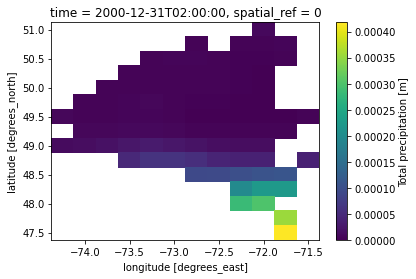

In [7]:
# Map of precip snapshot
ds.pr.isel(time=2).rio.clip(shdf, crs=ds.pr.rio.crs).plot()

In [8]:
sub.pr

<xarray.DataArray 'pr' (time: 17545)>
array([1.9725623e-05, 2.7161006e-05, 3.7725804e-05, ..., 7.4663832e-05,
       5.3332824e-05, 3.2710970e-05], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2000-12-31 ... 2003-01-01
    spatial_ref  int64 0
Attributes:
    units:         m
    long_name:     Total precipitation
    grid_mapping:  spatial_ref

In [9]:
# Model configuration parameters
config = dict(
    start_date=start,
    end_date=stop,
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_' + dataset + '_' + hydromodel,
    nc_spec= nc_transforms
)


In [10]:
# Here is where the magic happens, and the RAVEN modeling framework parses the information that we give it
# to run the hydrological model that we chose with the dataset that we chose.

# Here we provide a set of hydrological model parameters by default, but these can be adjusted, modified or calibrated later.
if hydromodel=='HMETS':
    params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919,2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'
    resp = wps.raven_hmets(ts=str(tsfile), params=params, rain_snow_fraction='RAINSNOW_DINGMAN', **config,)

elif hydromodel=='GR4JCN':
    params = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
    resp = wps.raven_gr4j_cemaneige(ts=str(tsfile), params = params, **config)

elif hydromodel=='MOHYSE':
    params = '1.00, 0.0468, 4.2952, 2.6580, 0.4038, 0.0621, 0.0273, 0.0453'
    hrus = '0.9039, 5.6179775' # MOHYSE has a particular setup that requires parameters for HRUs.
    resp = wps.raven_mohyse(ts=str(tsfile), params = params, hrus=hrus, rain_snow_fraction='RAINSNOW_DINGMAN', **config)

elif hydromodel=='HBVEC':
    params = '0.05984519, 4.072232, 2.001574, 0.03473693, 0.09985144, 0.5060520, 3.438486, 38.32455, 0.4606565, 0.06303738, 2.277781, 4.873686, 0.5718813, 0.04505643, 0.877607, 18.94145, 2.036937, 0.4452843, 0.6771759, 1.141608, 1.024278'
    resp = wps.raven_hbv_ec(ts=str(tsfile), evaporation="PET_OUDIN", ow_evaporation="PET_OUDIN", params=params, **config)


In [11]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy them locally.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file:

In [12]:
print(diagnostics)

:TimeStamp 2002-12-31 00:00:00.00
:HRUStateVariableTable
  :Attributes,SURFACE_WATER,ATMOSPHERE,ATMOS_PRECIP,PONDED_WATER,SOIL[0],SOIL[1],SNOW,SNOW_LIQ,CUM_SNOWMELT,CONVOLUTION[0],CONVOLUTION[1],AET,CONV_STOR[0],CONV_STOR[1],CONV_STOR[2],CONV_STOR[3],CONV_STOR[4],CONV_STOR[5],CONV_STOR[6],CONV_STOR[7],CONV_STOR[8],CONV_STOR[9],CONV_STOR[10],CONV_STOR[11],CONV_STOR[12],CONV_STOR[13],CONV_STOR[14],CONV_STOR[15],CONV_STOR[16],CONV_STOR[17],CONV_STOR[18],CONV_STOR[19],CONV_STOR[20],CONV_STOR[21],CONV_STOR[22],CONV_STOR[23],CONV_STOR[24],CONV_STOR[25],CONV_STOR[26],CONV_STOR[27],CONV_STOR[28],CONV_STOR[29],CONV_STOR[30],CONV_STOR[31],CONV_STOR[32],CONV_STOR[33],CONV_STOR[34],CONV_STOR[35],CONV_STOR[36],CONV_STOR[37],CONV_STOR[38],CONV_STOR[39],CONV_STOR[40],CONV_STOR[41],CONV_STOR[42],CONV_STOR[43],CONV_STOR[44],CONV_STOR[45],CONV_STOR[46],CONV_STOR[47],CONV_STOR[48],CONV_STOR[49],CONV_STOR[50],CONV_STOR[51],CONV_STOR[52],CONV_STOR[53],CONV_STOR[54],CONV_STOR[55],CONV_STOR[56],CONV_STOR[57]

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools.

In [13]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 730, nbasins: 1)>
array([[   0.      ],
       [1804.451682],
       [3571.474031],
       ...,
       [ 320.8941  ],
       [ 315.346364],
       [ 308.725969]])
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2002-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

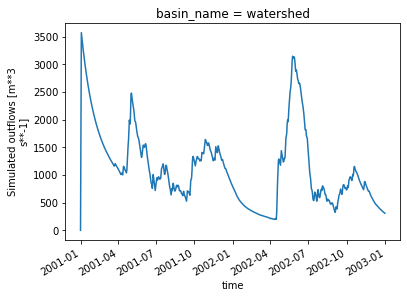

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [15]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(3571.47403105)
Mean:  <xarray.DataArray 'q_sim' ()>
array(1118.65174296)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[1610.77513767],
       [1062.01844332],
       [ 763.18475401],
       [ 954.10334426],
       [2052.9417887 ],
       [1705.82474503],
       [ 882.85181406],
       [ 669.93577581],
       [ 708.16541151],
       [1164.6374292 ],
       [1091.90353916],
       [ 751.52680269]])
Coordinates:
    basin_name  (nbasins) object 'watershed'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins


If we want, we can also download the simulation data and analyze it on our own computer, software and tools:

In [16]:
# Re-extract the WPS Server response, but this time set the "asobj" to False to return the file path.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=False)
print(hydrograph)
print(storage)
print(solution)
print(diagnostics)
print(rv)

http://localhost:9099/outputs/a3ef59e6-22e0-11eb-aa9a-a44cc85b43bf/test_ERA5_HMETS-0_Hydrographs.nc
http://localhost:9099/outputs/a3ef59e6-22e0-11eb-aa9a-a44cc85b43bf/test_ERA5_HMETS-0_WatershedStorage.nc
http://localhost:9099/outputs/a3ef59e6-22e0-11eb-aa9a-a44cc85b43bf/test_ERA5_HMETS-0_solution.rvc
http://localhost:9099/outputs/a3ef59e6-22e0-11eb-aa9a-a44cc85b43bf/test_ERA5_HMETS-0_solution_174lfvgy.rvc
http://localhost:9099/outputs/a3ef59e6-22e0-11eb-aa9a-a44cc85b43bf/rv.zip
